In [564]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import missingno as msno

Carga y reducción de registros de datasets

In [565]:
movies_df = pd.read_csv(r"E:\Repositorios y bases de datos\Henry DS\Proyecto-individual-N-1---LABS---Henry\datos_procesados\movies_df.csv")
director_actor_df = pd.read_csv(r"E:\Repositorios y bases de datos\Henry DS\Proyecto-individual-N-1---LABS---Henry\datos_procesados\director_actor_df.csv")

In [566]:
# Eliminación de columnas que pueden haber sido útiles para los endpoints pero que no usaría como parámentro para recoemndar
movies_df = movies_df.drop(columns=['original_title', 'release_date', 'return'])

movies_df

,budget,movie_id,revenue,title,vote_average,vote_count,genre
0,30000000.0,862,373554033.0,Toy Story,7.7,5415.0,Animation
1,65000000.0,8844,262797249.0,Jumanji,6.9,2413.0,Adventure
2,0.0,15602,0.0,Grumpier Old Men,6.5,92.0,Romance
3,16000000.0,31357,81452156.0,Waiting to Exhale,6.1,34.0,Comedy
4,0.0,11862,76578911.0,Father of the Bride Part II,5.7,173.0,Comedy
...,...,...,...,...,...,...,...
45461,0.0,439050,0.0,Subdue,4.0,1.0,Drama
45462,0.0,111109,0.0,Century of Birthing,9.0,3.0,Drama
45463,0.0,67758,0.0,Betrayal,3.8,6.0,Action
45464,0.0,227506,0.0,Satan Triumphant,0.0,0.0,Not available


## Análisis

Descripción

In [567]:
movies_df.dtypes

budget          float64
movie_id         object
revenue          object
title            object
vote_average     object
vote_count       object
genre            object
dtype: object

In [568]:
director_actor_df.dtypes

Unnamed: 0     int64
movie_id       int64
director      object
actor         object
dtype: object

In [569]:
# Primeras filas del dataset
print(movies_df.head())

# Información general del dataset
print(movies_df.info())

# Estadística descriptiva
print(movies_df.describe())


       budget movie_id      revenue                        title vote_average  \
0  30000000.0      862  373554033.0                    Toy Story          7.7   
1  65000000.0     8844  262797249.0                      Jumanji          6.9   
2         0.0    15602          0.0             Grumpier Old Men          6.5   
3  16000000.0    31357   81452156.0            Waiting to Exhale          6.1   
4         0.0    11862   76578911.0  Father of the Bride Part II          5.7   

  vote_count      genre  
0     5415.0  Animation  
1     2413.0  Adventure  
2       92.0    Romance  
3       34.0     Comedy  
4      173.0     Comedy  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   budget        45466 non-null  float64
 1   movie_id      45466 non-null  object 
 2   revenue       45466 non-null  object 
 3   title         45466 non-null 

In [570]:
director_actor_df = director_actor_df.drop(columns=['Unnamed: 0'])

print(director_actor_df.head())
print(director_actor_df.info())
print(director_actor_df.describe())

   movie_id         director  \
0       862    John Lasseter   
1      8844     Joe Johnston   
2     15602    Howard Deutch   
3     31357  Forest Whitaker   
4     11862    Charles Shyer   

                                               actor  
0  ['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...  
1  ['Robin Williams', 'Jonathan Hyde', 'Kirsten D...  
2  ['Walter Matthau', 'Jack Lemmon', 'Ann-Margret...  
3  ['Whitney Houston', 'Angela Bassett', 'Loretta...  
4  ['Steve Martin', 'Diane Keaton', 'Martin Short...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42568 entries, 0 to 42567
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  42568 non-null  int64 
 1   director  42568 non-null  object
 2   actor     42568 non-null  object
dtypes: int64(1), object(2)
memory usage: 997.8+ KB
None
            movie_id
count   42568.000000
mean   103587.573858
std    110421.188224
min         2.000000
25%     25032.750

Chequeo valores nulos

In [571]:
print(movies_df.isnull().sum())


budget          0
movie_id        0
revenue         0
title           0
vote_average    0
vote_count      0
genre           0
dtype: int64


In [572]:
print(director_actor_df.isnull().sum())

movie_id    0
director    0
actor       0
dtype: int64


Chequeo de duplicados

In [573]:
duplicates = movies_df.duplicated()
print(duplicates)


0        False
1        False
2        False
3        False
4        False
         ...  
45461    False
45462    False
45463    False
45464    False
45465    False
Length: 45466, dtype: bool


In [574]:
duplicates = director_actor_df.duplicated()
print(duplicates)

0        False
1        False
2        False
3        False
4        False
         ...  
42563    False
42564    False
42565    False
42566    False
42567    False
Length: 42568, dtype: bool


Chequeo de faltantes

In [575]:
zero_as_missing = (director_actor_df == 0).sum()
print("Valores iguales a 0 contados como faltantes por columna:")
print(zero_as_missing)

Valores iguales a 0 contados como faltantes por columna:
movie_id    0
director    0
actor       0
dtype: int64


In [576]:
zero_as_missing = (movies_df == 0).sum()
print("Valores iguales a 0 contados como faltantes por columna:")
print(zero_as_missing)

Valores iguales a 0 contados como faltantes por columna:
budget          36576
movie_id            0
revenue             0
title               0
vote_average        0
vote_count          0
genre               0
dtype: int64


<sus>Por esta razón, los análisis que tomen los valores de 'budget', 'revenue', 'vote average' y vote 'count' se tomarán con precaución.</sus>

## movies_df Gráficos

Histograma

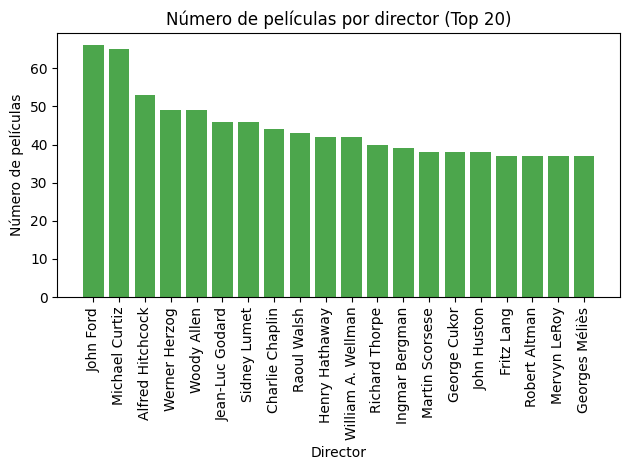

In [577]:
import matplotlib.pyplot as plt

# Recuento de la cantidad de películas por cada director
director_counts = director_actor_df['director'].value_counts()

# Límite a los primeros 20 directores más frecuentes para visualización
top_directors = director_counts.head(20)

# Creación del histograma
plt.bar(top_directors.index, top_directors.values, color='green', alpha=0.7)
plt.xlabel('Director')
plt.ylabel('Número de películas')
plt.title('Número de películas por director (Top 20)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


 <sub> 
<p>- John Ford y Michael Curtiz lideran la lista con más de 60 películas cada uno, destacándose significativamente del resto.</p>  
<p>- Hay una notable consistencia entre los directores del top 20, con la mayoría produciendo entre 35 y 50 películas.</p>
<p>- Incluso el director en el puesto 20 tiene cerca de 40 películas, lo que indica una alta productividad entre los directores más destacados.</p>
<p>- Todos los directores en el top 20 son hombres, lo que podría reflejar un sesgo histórico en la industria cinematográfica.</p>
</sub>

C:\Users\Germán\AppData\Local\Temp\ipykernel_6436\172720109.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movies_df['revenue'].fillna(0, inplace=True)


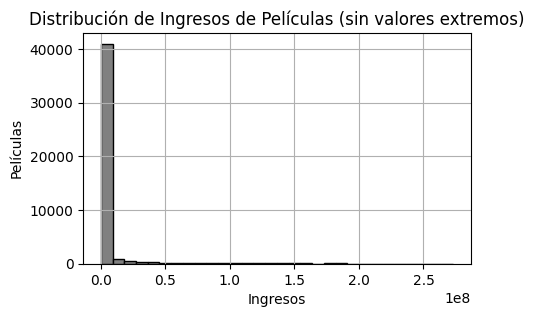

In [578]:
#Conversión a numérico
movies_df['revenue'] = pd.to_numeric(movies_df['revenue'], errors='coerce')
movies_df['revenue'].fillna(0, inplace=True)

# Definición del umbral para filtrar valores extremos
umbral_superior = movies_df['revenue'].quantile(0.99)

# Filtro de valores extremos
df_movies_filtered = movies_df[movies_df['revenue'] <= umbral_superior]

# Histograma
plt.figure(figsize=(5, 3))
plt.hist(df_movies_filtered['revenue'], bins=30, edgecolor='black', color='grey')
plt.title('Distribución de Ingresos de Películas (sin valores extremos)')
plt.xlabel('Ingresos')
plt.ylabel('Películas')
plt.grid(True)
plt.show()

<sub>La mayoría de las películas tienen ingresos bajos, con una distribución muy sesgada hacia la izquierda.</sub>

Selección de columnas numéricas y cálculo de la matriz de correlación
<sub>(se consideran los resultados con precaución debido a los valores faltantes)</sub>

In [579]:
# Elección de columnas para números
numeric_cols = ['budget', 'revenue', 'vote_average', 'vote_count']

# Conversión de valores no numericos a NaN
movies_df[numeric_cols] = movies_df[numeric_cols].replace('Not available', np.nan)

# Conversión a tipo numérico
movies_df[numeric_cols] = movies_df[numeric_cols].apply(pd.to_numeric)


# Cálculo de la matriz de correlación
correlation_matrix = movies_df[numeric_cols].corr()
print(correlation_matrix)

                budget   revenue  vote_average  vote_count
budget        1.000000  0.768777      0.073494    0.676642
revenue       0.768777  1.000000      0.083868    0.812022
vote_average  0.073494  0.083868      1.000000    0.123607
vote_count    0.676642  0.812022      0.123607    1.000000


Heatmap

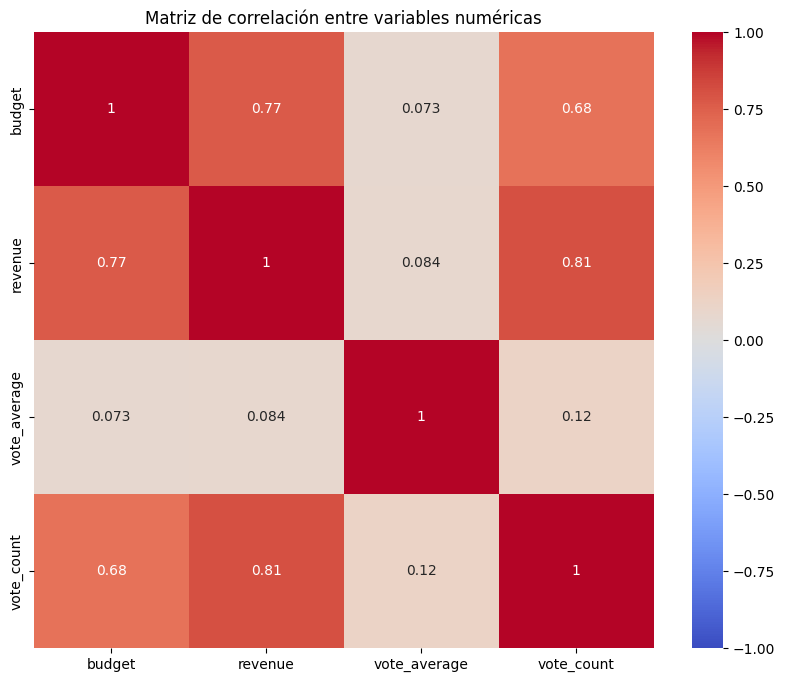

In [580]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de correlación entre variables numéricas')
plt.show()

<sub>Las películas con mayores ingresos tienden a tener un mayor número de votos, según revenue y vote_count.
Las películas con mayor presupuesto tienden a tener mayores ingresos, un mayor número de votos y una calificación promedio más alta.<sub/>



Gráfico de barras

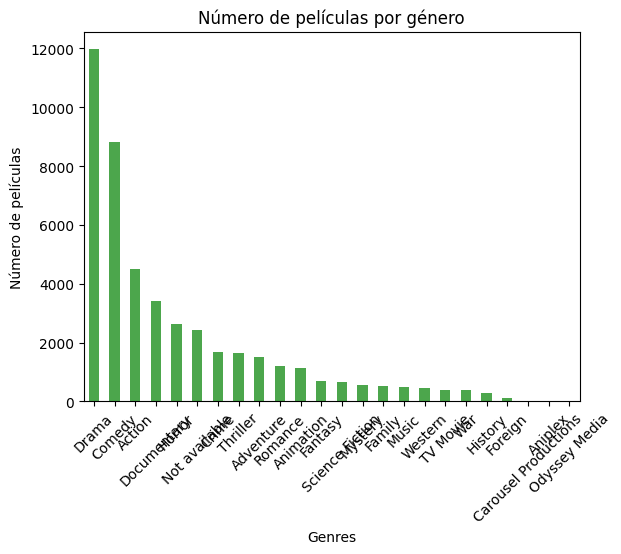

In [581]:
genre_counts = movies_df['genre'].value_counts()
genre_counts.plot(kind='bar', color='green', alpha=0.7)
plt.xlabel('Genres')
plt.ylabel('Número de películas')
plt.title('Número de películas por género')
plt.xticks(rotation=45)
plt.show()

<sub>Preferencia por ciertos géneros, con el drama y la comedia dominando significativamente.</sub>

Diagrama de dispersión

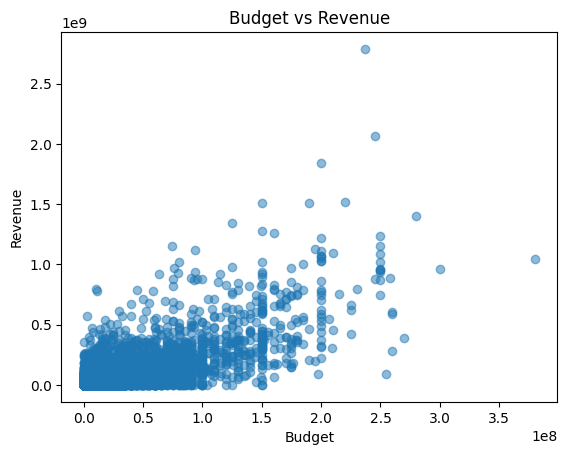

In [582]:
plt.scatter(movies_df['budget'], movies_df['revenue'], alpha=0.5)
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.title('Budget vs Revenue')
plt.show()

<sub>Los mayores presupuestos suelen generar más ingresos. La dispersión de los puntos indica que tal relación no es siempre garantía de éxito. La mayoría de las películas se concentran en presupuestos e ingresos bajos, con algunos outliers entre la relación de presupuesto y retornos, pero no necesariamente son errores. Estos son algunos positivos y otros negativos entre la relación de valores.</sub>

Nube de palabras según el título de la película

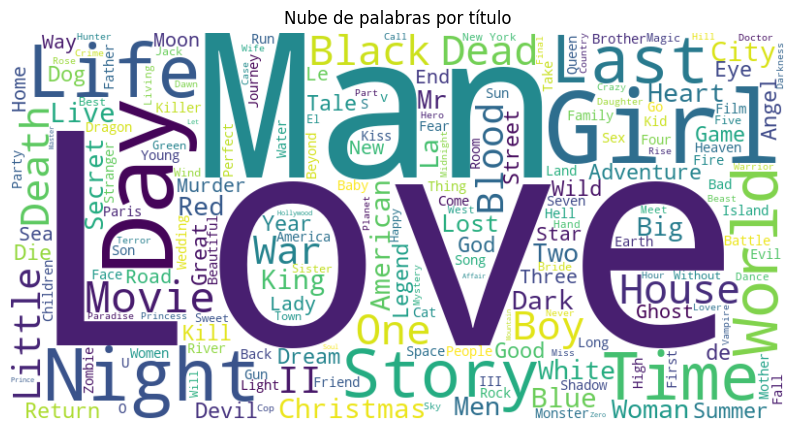

In [583]:
# Concatenación de todos los títulos en un solo string
text = ' '.join(movies_df['title'].astype(str))

# Creación de la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Muestra de la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras por título')
plt.show()

Nube de palabras de género

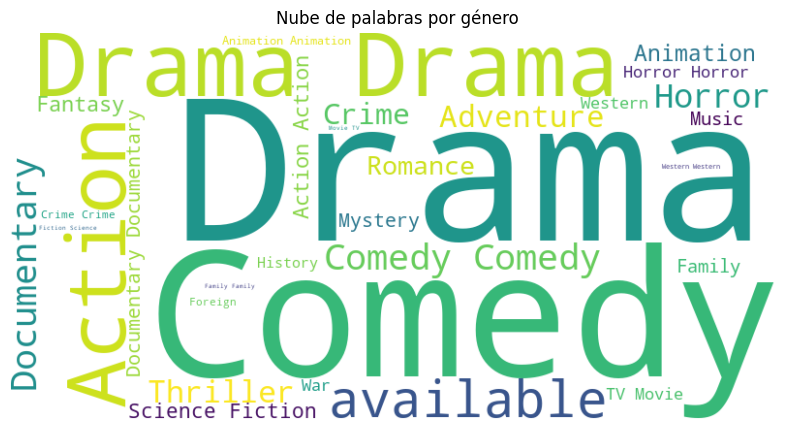

In [584]:
# Concatenación de todos los títulos en un solo string
text = ' '.join(movies_df['genre'].astype(str))

# Creación de la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Muestra de la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras por género')
plt.show()

## director_actor_df Gráficos

Nube de palabras según directores

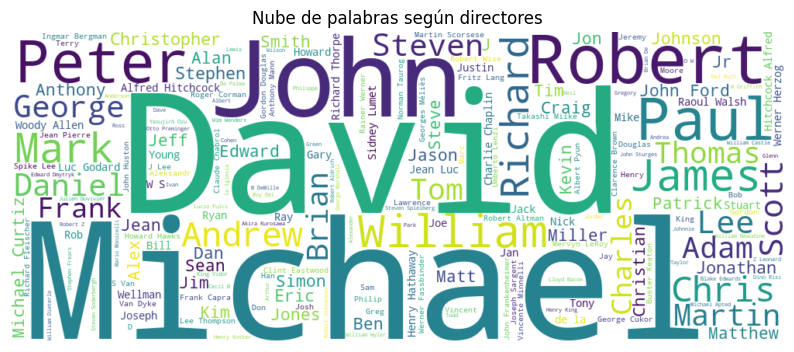

In [585]:
director_names = director_actor_df['director'].str.split(' ')

# Concatenación de nombres y apellidos de directores en un solo string
text_directors = ' '.join([' '.join(name) for name in director_names])

# Creación de la nube de palabras para directores
wordcloud_directors = WordCloud(width=1000, height=400, background_color='white').generate(text_directors)

# Muestra de la nube de palabras para directores
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_directors, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras según directores')
plt.show()

Nube de palabras según actores

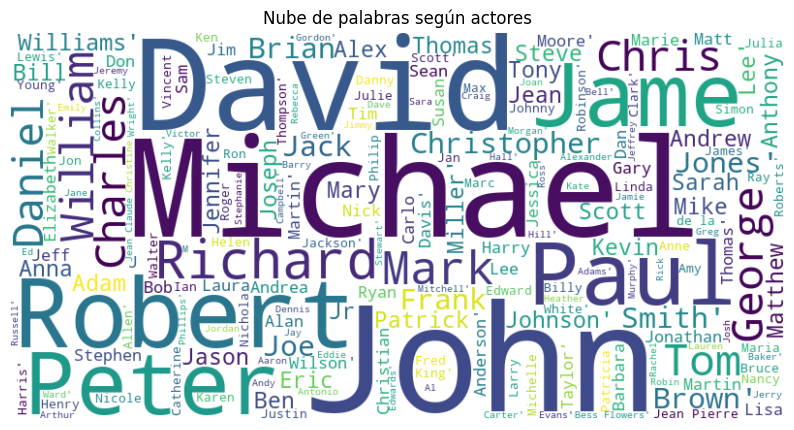

In [586]:
actor_names = director_actor_df['actor'].str.split(' ')

# Concatenación de nombres y apellidos de actores en un solo string
text_actors = ' '.join([' '.join(name) for name in actor_names])

# Creación de la nube de palabras para actores
wordcloud_actors = WordCloud(width=800, height=400, background_color='white').generate(text_actors)

# Muestra de la nube de palabras para actores
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_actors, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras según actores')
plt.show()